# _Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-04-23, 9am

Student names: *{1,2}:Weiyi Xiao, {3,4}:Shanqian Ma*

# Exercise sheet 1

Download the data file ```nda_ex1.csv``` from ILIAS and save it in a subfolder ```../data/```.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
import scipy as sp
import itertools as it
sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
Fs = 30000     # sampling rate of the signal in Hz
dt = 1/Fs
gain = .5      # gain of the signal
x = pd.read_csv('data//nda_ex_1.csv', names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))  
x.head()

,Ch1,Ch2,Ch3,Ch4
0,-151,-188,-327,-200
1,-141,-184,-316,-191
2,-136,-167,-290,-196
3,-168,-185,-306,-219
4,-147,-188,-332,-219


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filterSignal()```. A typical choice for this task would be a butterworth filter. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [3]:
def filterSignal(x, Fs, low, high):
# Filter raw signal
#   y = filterSignal(x, Fs, low, high) filters the signal x. Each column in x is one
#   recording channel. Fs is the sampling frequency. low and high specify the passband in Hz.
#   The filter delay is compensated in the output y.

    nyq = 0.5 * Fs  # nyquist frequency
    lowcut = low/nyq
    highcut = high/nyq
    order = 5
    b, a = signal.butter(order, [lowcut,highcut], 'bandpass')
    y = signal.filtfilt(b,a,x,axis=0)  # filter delay compensation, apply filter along the column
    y = pd.DataFrame(data=y, columns=['Ch1', 'Ch2', 'Ch3', 'Ch4']) # convert to DataFrame object for plot
    
    return y


In [4]:
xf = filterSignal(x, Fs, 500, 4000)

In [5]:
print(xf.shape[0])

19200000


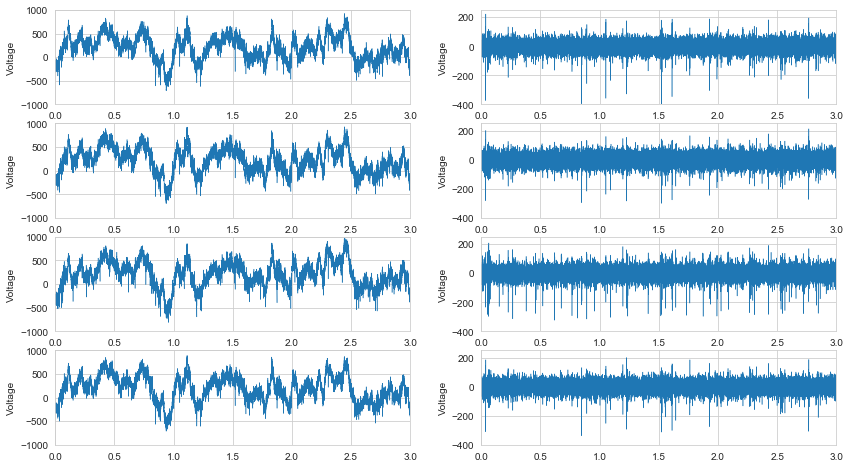

In [6]:
plt.figure(figsize=(14, 8))

T = 100000
t = np.arange(0,T) * dt 

for i, col in enumerate(xf):
    plt.subplot(4,2,2*i+1)
    plt.plot(t,x[col][0:T],linewidth=.5)
    plt.ylim((-1000, 1000))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    
    
    plt.subplot(4,2,2*i+2)
    plt.plot(t,xf[col][0:T],linewidth=.5)
    plt.ylim((-400, 250))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detectSpikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. Plot the threshold. Are the detected time points well aligned with peaks in the signal?

*Grading: 3 pts*

In [12]:
def detectSpikes(x,Fs):
# Detect spikes
# s, t = detectSpikes(x,Fs) detects spikes in x, where Fs the sampling
#   rate (in Hz). The outputs s and t are column vectors of spike times in
#   samples and ms, respectively. By convention the time of the zeroth
#   sample is 0 ms.
    dt = 1000/Fs  # in ms
    sigma = np.median(abs(x)/0.6745)  # estimate of the standard deviation of the background noise
    thr = 4*sigma
    data = np.amax(-x,axis=1)  # find the maximum amplitude at each sample position
    s,_ = signal.find_peaks(data, height=thr, distance=16)  # detect spike position, unit: [samples]  
    t = s*dt  # spike position, unit: [ms]
        
    return (s, t)


In [13]:
# estimate of the standard deviation of the background noise
# and decide whether to use one threshold for all channel or one threshold for each channel
sigma = np.median(abs(xf.values)/0.6745,axis=0)  
print(sigma)
sigma = np.median(abs(xf.values)/0.6745)  # estimate of the standard deviation of the background noise
print(sigma)
threshold = 4*sigma

[33.83454136 35.60607803 36.2080001  34.36803401]
34.98257095049142


In [14]:
T = xf.shape[0]
s, t = detectSpikes(xf.values,Fs)
print(s.shape)

(33461,)


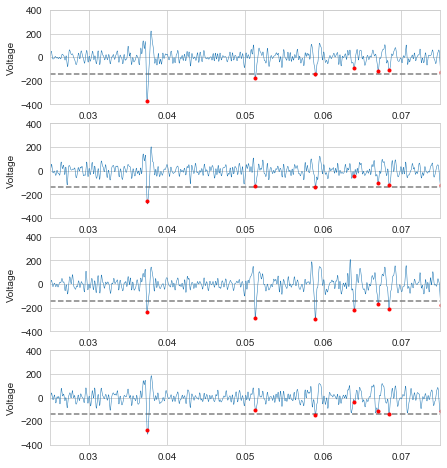

In [15]:
plt.figure(figsize=(7, 8))

tt = np.arange(0,T) * dt 

for i, col in enumerate(xf):
    plt.subplot(4,1,i+1)
    plt.plot(tt,xf[col],linewidth=.5)
    plt.plot(tt[s],xf[col][s],'r.')  
    plt.hlines(-threshold,0.025,0.075,'grey','dashed')
    plt.ylim((-400, 400))
    plt.xlim((0.025,0.075))
    plt.ylabel('Voltage')



### The detected time points were roughly aligned with the peaks in the signal. Sometimes the peak was aligned with the detected time points in some channel, but shift slightly in the orther channels. This could be due to the environmental noise or different conduction speed between electrodes.

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extractWaveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

### Most of the detected spikes look nice which gives a sharp peak, so the threshold works fine for this four channels. There are some slight shift for peaks detected at different channels which could be due to environmental noise. Apart from that, we did't see obvious artifacts.

In [16]:
def extractWaveforms(x, s):
# Extract spike waveforms.
#   w = extractWaveforms(x, s) extracts the waveforms at times s (given in
#   samples) from the filtered signal x using a fixed window around the
#   times of the spikes. The return value w is a 3d array of size
#   length(window) x #spikes x #channels.
    w=np.zeros([30,len(s),x.shape[1]])
    for i in range(0,len(s)):
        w[:,i,:]=x[s[i]-10:s[i]+20,:] # extract the period 10ms before to 20ms after detected peaks
    return w

    

In [17]:
w = extractWaveforms(xf.values,s)

Plot first 100 spike waveforms

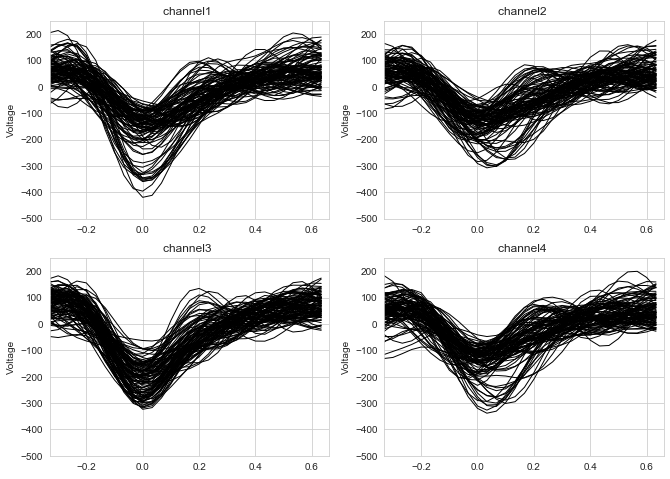

In [18]:
t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))

for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,1:100,i],'k', linewidth=1)
    plt.ylim((-500, 250))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')
    plt.title('channel%u ' % (i+1))


Plot largest 100 spike waveforms

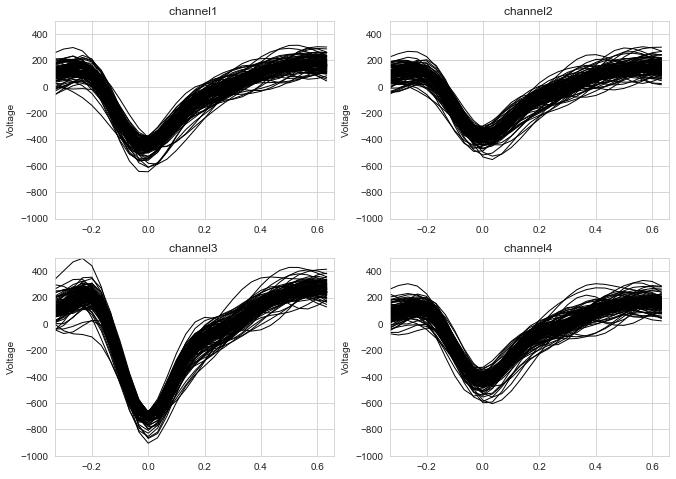

In [19]:
idx = np.argsort(np.min(np.min(w,axis=2),axis=0))


t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,idx[0:100],i],'k', linewidth=1)
    plt.ylim((-1000, 500))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')
    plt.title('channel%u ' % (i+1))


## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extractFeatures()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


### From the PCA scores ploting, at least two clusters can be recognized (since the data is too dense in the plot, we uses transparent dots to see the cluster pattern). We observed that when channel 3 involved, the plot tends to show three clusters. Maybe the location or recording sensitivity of channel 3 is somehow different from other channels.

In [20]:
def extractFeatures(w):
# Extract features for spike sorting.
#   b = extractFeatures(w) extracts features for spike sorting from the
#   waveforms in w, which is a 3d array of size length(window) x #spikes x
#   #channels. The output b is a matrix of size #spikes x #features.
#   The implementation should do PCA on the waveforms of each channel
#   separately and uses the first three principal components. Thus, we get
#   a total of 12 features. Also, the varianced explained by the 3 features per channel
#   should be computed.
    pca = PCA(svd_solver='full')
    
    expVar=[] # to save variance explained
    pc_scores=np.zeros([4,w.shape[1],3]) #to save features for single channels temporarily
    
    for ch in range(0,x.shape[1]): # Run PCA for each channel
        PCs=np.zeros([w.shape[0],3])
        pca.fit(w[:,:,ch].T)
        expVar.append(pca.explained_variance_ratio_[0:3])
        print("3 PC's variance explained for channel %u"%(ch), pca.explained_variance_ratio_[0:3])
        PCs=pca.components_.T[:,0:3] #Need transpose: components original shape(n-components,n-features)
        ## Compute PCA scores using retained components
        center_mat=w[:,:,ch].T-w[:,:,ch].mean(axis=1)
        pc_scores[ch]=np.matmul(center_mat,PCs)
        
    b=np.concatenate((pc_scores[0],pc_scores[1],pc_scores[2],pc_scores[3]),axis=1)
    
    return b



In [21]:
b = extractFeatures(w)

3 PC's variance explained for channel 0 [0.57288535 0.16689021 0.0785004 ]
3 PC's variance explained for channel 1 [0.4523469  0.20329618 0.10281311]
3 PC's variance explained for channel 2 [0.51916217 0.19051748 0.09107299]
3 PC's variance explained for channel 3 [0.47284836 0.20019367 0.102483  ]


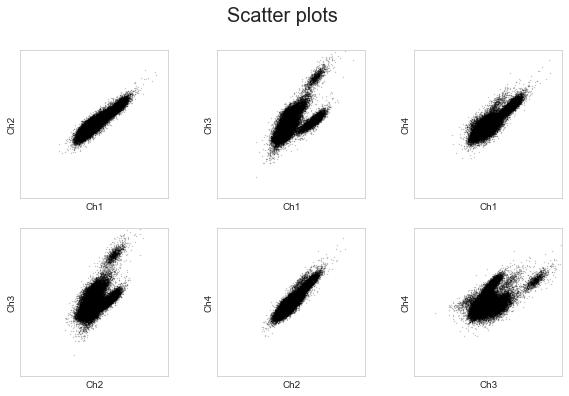

In [28]:
plt.figure(figsize=(10, 6))
plt.suptitle('Scatter plots',fontsize=20)

idx = [0, 3, 6, 9]
p = 1
labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,p, aspect='equal')
        plt.plot(b[:,idx[i]],b[:,idx[j]],'.k', markersize=.7,alpha=0.3) 
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-1500,1500))
        plt.ylim((-1500,1500))
        ax.set_xticks([])
        ax.set_yticks([])
        p = p+1

In [25]:
np.save('data//nda_ex_1_features',b)
np.save('data//nda_ex_1_spiketimes',s)
np.save('data//nda_ex_1_waveforms',w)